# Machine Learning Using Sci-Kit Learn

In [1]:
import nltk, random
from nltk.corpus import movie_reviews

## Data Loading

In [2]:
print(len(movie_reviews.fileids()))
print(movie_reviews.categories())
print(movie_reviews.words()[:100])
print(movie_reviews.fileids()[:10])

2000
['neg', 'pos']
['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]
['neg/cv000_29416.txt', 'neg/cv001_19502.txt', 'neg/cv002_17424.txt', 'neg/cv003_12683.txt', 'neg/cv004_12641.txt', 'neg/cv005_29357.txt', 'neg/cv006_17022.txt', 'neg/cv007_4992.txt', 'neg/cv008_29326.txt', 'neg/cv009_29417.txt']


In [3]:
# category of the first 10 documents
[ c for c in [movie_reviews.categories(f) for f in movie_reviews.fileids()[:10]]]
    

[['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg'],
 ['neg']]

In [4]:
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

In [5]:
print('Number of Reviews/Documents: {}'.format(len(documents)))
print('Sample Text of Doc 1:')
print('-'*30)
print(' '.join(documents[0][0][:50])) # first 50 words of the first document

Number of Reviews/Documents: 2000
Sample Text of Doc 1:
------------------------------
when a someone journeys to the theater to see a comedy , he always risks having to sit through inanity such as what we recently saw in films like edtv and office space . it really is too bad that comedies are so hit - and - miss , because


In [6]:
## Check Sentiment Distribution of the Current Dataset
from collections import Counter
sentiment_distr = Counter([label for (words, label) in documents])
print(sentiment_distr)

Counter({'pos': 1000, 'neg': 1000})


## Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(documents, test_size = 0.33, random_state=42)

In [8]:
## Sentiment Distrubtion for Train and Test
print(Counter([label for (words, label) in train]))
print(Counter([label for (words, label) in test]))

Counter({'pos': 687, 'neg': 653})
Counter({'neg': 347, 'pos': 313})


In [9]:
X_train = [' '.join(words) for (words, label) in train]
X_test = [' '.join(words) for (words, label) in test]
y_train = [label for (words, label) in train]
y_test = [label for (words, label) in test]

## Text Vectorization

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X_train_bow = tfidf_vec.fit_transform(X_train) # fit train
X_test_bow = tfidf_vec.transform(X_test) # transform test

In [11]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(1340, 33537)
(660, 33537)


```{warning}

- Always split the data into train and test first before vectorizing the texts
- Otherwise, you would leak information to the training process, which may lead to over-fitting
- When vectorizing the texts, `fit_transform()` the train and `transform()` the test
```

## Models

### SVM

In [24]:
from sklearn import svm

model_svm = svm.SVC(C=8.0, kernel='linear')
model_svm.fit(X_train_bow, y_train)

SVC(C=8.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [13]:
model_svm.predict(X_test_bow[:10])
#print(model_svm.score(test_text_bow, test_label))

array(['neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'pos',
       'neg'], dtype='<U3')

### Decision Tree

In [61]:
from sklearn.tree import DecisionTreeClassifier

model_dec = DecisionTreeClassifier(max_depth=5, random_state=0)
model_dec.fit(X_train_bow, y_train)

model_dec.predict(X_test_bow[:10])

array(['neg', 'pos', 'neg', 'neg', 'neg', 'pos', 'pos', 'neg', 'pos',
       'neg'], dtype='<U3')

### Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
model_gnb = GaussianNB()
model_gnb.fit(X_train_bow.toarray(), y_train)

model_gnb.predict(X_test_bow[:10].toarray())

array(['neg', 'pos', 'pos', 'neg', 'pos', 'pos', 'pos', 'neg', 'neg',
       'pos'], dtype='<U3')

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

model_lg = LogisticRegression()
model_lg.fit(X_train_bow, y_train)

model_lg.predict(X_test_bow[:10].toarray())

array(['neg', 'pos', 'pos', 'pos', 'pos', 'neg', 'neg', 'neg', 'pos',
       'neg'], dtype='<U3')

## Evaluation

In [62]:
#Mean Accuracy
print(model_svm.score(X_test_bow, y_test))
print(model_dec.score(X_test_bow, y_test))
print(model_gnb.score(X_test_bow.toarray(), y_test))
print(model_lg.score(X_test_bow, y_test))

0.8515151515151516
0.6348484848484849
0.6318181818181818
0.8106060606060606


In [18]:
# F1
from sklearn.metrics import f1_score

f1_score(y_test, model_svm.predict(X_test_bow), 
         average=None, 
         labels = movie_reviews.categories())

array([0.8320951 , 0.82534776])

In [19]:
## try a whole new self-created review:)
new_review =['This book looks soso like the content but the cover is weird',
             'This book looks soso like the content and the cover is weird'
            ]
new_review_bow = tfidf_vec.transform(new_review)
model_svm.predict(new_review_bow)

array(['neg', 'neg'], dtype='<U3')

## Tuning Model Hyperparameters - Grid Search

In [20]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {'kernel': ('linear', 'rbf'), 'C': (1,4,8,16,32)}

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(X_train_bow, y_train)

CPU times: user 3min 9s, sys: 565 ms, total: 3min 9s
Wall time: 3min 12s


GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': (1, 4, 8, 16, 32), 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [21]:
sorted(clf.cv_results_.keys())
print(clf.best_params_)

{'C': 8, 'kernel': 'linear'}


In [22]:
print(clf.score(X_test_bow, y_test))

0.8515151515151516


## Post-hoc Analysis

- Some of the online code snippets try to implement the `show_most_informative_features()` in `nltk` classifier.
- Here the codes only work with linear classifiers (e.g., Logistic models) in sklearn.
- Need more updates. See this [SO post](https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers)

In [55]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

In [58]:
show_most_informative_features(tfidf_vec, model_lg, n=20)

	-2.2174	bad            		2.4816	and            
	-1.3605	movie          		1.7498	is             
	-1.2918	plot           		1.2166	great          
	-1.2638	have           		1.1359	his            
	-1.2452	worst          		1.1203	as             
	-1.2410	to             		1.1093	jackie         
	-1.1538	no             		1.0518	war            
	-1.1220	script         		1.0366	truman         
	-1.1205	there          		0.9813	life           
	-1.0810	nothing        		0.9014	the            
	-1.0585	this           		0.8601	most           
	-1.0409	harry          		0.8471	very           
	-1.0297	boring         		0.8201	well           
	-0.9738	if             		0.8120	also           
	-0.9602	only           		0.7481	world          
	-0.9042	why            		0.7375	many           
	-0.8502	stupid         		0.7025	excellent      
	-0.8289	or             		0.6798	will           
	-0.8056	any            		0.6758	fiction        
	-0.8043	looks          		0.6502	fun            


For tree-based classifiers, visualization is better.

In [67]:
import sklearn
from sklearn.tree import plot_tree
text_representation = sklearn.tree.export_text(model_dec, feature_names = tfidf_vec.get_feature_names())
print(text_representation)




|--- bad <= 0.01
|   |--- and <= 0.14
|   |   |--- plot <= 0.01
|   |   |   |--- no <= 0.02
|   |   |   |   |--- poor <= 0.01
|   |   |   |   |   |--- class: pos
|   |   |   |   |--- poor >  0.01
|   |   |   |   |   |--- class: neg
|   |   |   |--- no >  0.02
|   |   |   |   |--- to <= 0.14
|   |   |   |   |   |--- class: neg
|   |   |   |   |--- to >  0.14
|   |   |   |   |   |--- class: neg
|   |   |--- plot >  0.01
|   |   |   |--- especially <= 0.01
|   |   |   |   |--- eventually <= 0.03
|   |   |   |   |   |--- class: neg
|   |   |   |   |--- eventually >  0.03
|   |   |   |   |   |--- class: pos
|   |   |   |--- especially >  0.01
|   |   |   |   |--- attempt <= 0.02
|   |   |   |   |   |--- class: pos
|   |   |   |   |--- attempt >  0.02
|   |   |   |   |   |--- class: neg
|   |--- and >  0.14
|   |   |--- lame <= 0.02
|   |   |   |--- wasted <= 0.02
|   |   |   |   |--- either <= 0.03
|   |   |   |   |   |--- class: pos
|   |   |   |   |--- either >  0.03
|   |   |   |   |   |

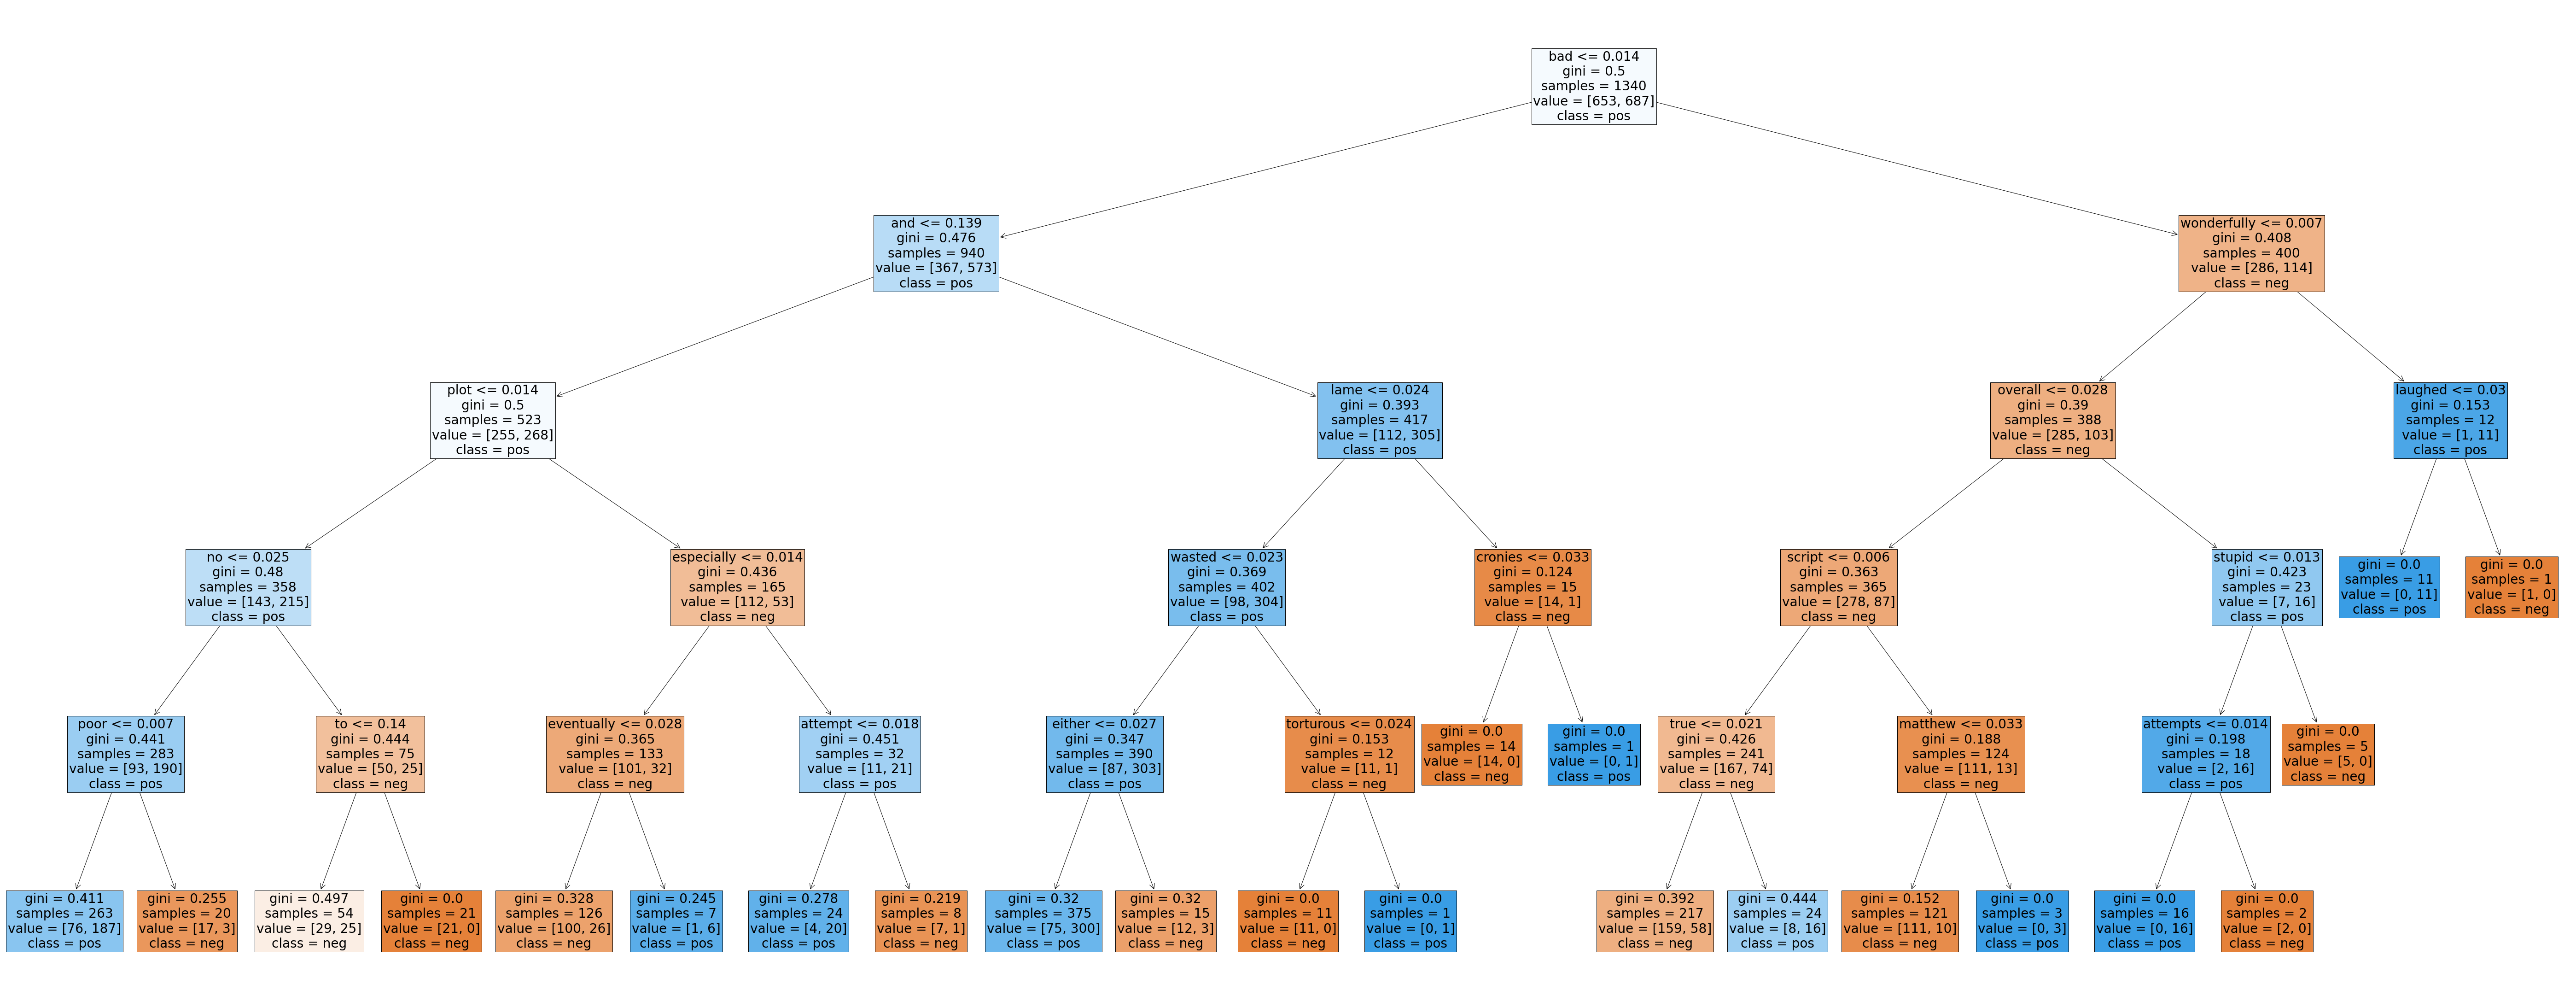

In [80]:

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(100,40))
_ = sklearn.tree.plot_tree(model_dec, 
                   feature_names=tfidf_vec.get_feature_names(),  
                   class_names=model_dec.classes_,
                   filled=True, fontsize=28)

#fig.savefig("decistion_tree.png")

## Saving Model


In [ ]:
#  import pickle

# with open('../ml-sent-svm.pkl', 'wb') as f:
#     pickle.dump(clf, f)
# with open('../ml-sent-svm.pkl' 'rb') as f:
#     loaded_svm = pickle.load(f)

## Package Requirement

In [82]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

In [81]:
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

scikit-learn==0.22.1
numpy==1.19.2
nltk==3.5
matplotlib==3.3.2


## References

- Geron (2019), Ch 2 and 3
- See [Keith Galli's sklearn tutorial](https://github.com/KeithGalli/sklearn)